# NetColoc analysis of rare variants in Autism spectrum disorder (ASD). 

Example of NetColoc workflow on genes associated with rare exome variants in childhjod demntia genes only, to demonstrate workflow from single gene set

run this in the base conda env. 




# _Obtain input gene sets and interactome_

## 1. Load required packages

In [5]:
# load required packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import re
import random

from IPython.display import display

import getpass
import ndex2

import json
import cdapsutil

from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

from scipy.stats import hypergeom
from scipy.stats import norm

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

sns.set(font_scale=1.4)

sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 15, "ytick.major.size": 15})
plt.rcParams['svg.fonttype'] = 'none'

from datetime import datetime
import sys
%matplotlib inline

In [50]:
# verify DDOT was installed
import ddot

from netcoloc import netprop_zscore, netprop, network_colocalization, validation


## 2. Select one gene set of interest. Load gene set from text files into python.


Identify one gene sets of interest. Gene sets should come from experimental data (not manual curation) to avoid bias. 

**Usage Note**: gene sets should be < 500 genes (propagation algorithm breaks down if seeded with larger sets). If your gene set is larger, only use the top 500 as seeds to the network propagation.



In [8]:
# set names of geneset 1
# ------ customize this section based on your gene sets and how they should be labeled -------
d1_name='ChildhoodDementia'


In [9]:
# ------ customize this section based your input genesets -------

# load rare variants Satterstrom et al 2020; PMID: 31981491
D1_df = pd.read_csv('genesets/childhooddementiagenes.csv')
D1_df.index = D1_df['GENE']
print('Number of '+d1_name+' genes:', len(D1_df))
D1_genes = D1_df.index.tolist() # define rare variant genes to seed network propagation
print("First 5 genes:", D1_genes[0:5])

Number of ChildhoodDementia genes: 235
First 5 genes: ['SGSH', 'NAGLU', 'HGSNAT', 'GNS', 'MTTP']


## 3. Select gene interaction network to use for the analysis.

Identify network UUID on NDEx (ndexbio.org) and use this to import to this Jupyter notebook. We recommend using PCNet as a starting point, but a user may want to switch to “STRING high confidence” if using a machine with low memory (< 8GB RAM).


In [10]:
interactome_uuid='4de852d9-9908-11e9-bcaf-0ac135e8bacf' # for PCNet
# interactome_uuid='275bd84e-3d18-11e8-a935-0ac135e8bacf' # for STRING high confidence
ndex_server='public.ndexbio.org'
ndex_user=None
ndex_password=None
G_int = ndex2.create_nice_cx_from_server(
            ndex_server, 
            username=ndex_user, 
            password=ndex_password, 
            uuid=interactome_uuid
        ).to_networkx()
nodes = list(G_int.nodes)

# remove self edges from network
G_int.remove_edges_from(nx.selfloop_edges(G_int))

# print out the numbers of nodes and edges in the interatome for diagnostic purposes:
print('Number of nodes:', len(G_int.nodes))
print('\nNumber of edges:', len(G_int.edges))

Number of nodes: 18820

Number of edges: 2693109


In [13]:
int_nodes = list(G_int.nodes)

# _Identify network colocalized gene network_

## 4. Precalculate matrices needed for propagation. This step should take a few minutes (more for larger/denser networks) 

A benchmarking analysis demonstrates that the runtime required scales with the number of edges (w’) and the number of nodes (w’’). NetColoc includes functionality for saving and loading these matrices, by setting the XXX parameter, which can be useful if running multiple analyses. The diffusion parameter, which controls the rate of propagation through the network, may be set in this step. In practice, we have found that results are not dependent on the choice of this parameter, and recommend using the default value of 0.5.

Background on network propagation: https://www.nature.com/articles/nrg.2017.38.pdf?origin=ppub


In [14]:
# pre-calculate matrices used for network propagation. this step takes a few minutes, more for denser interactomes
print('\ncalculating w_prime')
w_prime = netprop.get_normalized_adjacency_matrix(G_int, conserve_heat=True)

print('\ncalculating w_double_prime')
w_double_prime = netprop.get_individual_heats_matrix(w_prime, .5)

# w_double_prime can be saved to the file netcoloc_w_double_prime.npy
# in current working directory with the following call:
#
# np.save('netcoloc_w_double_prime.npy', w_double_prime)

# and reloaded later with:
# w_double_prime = np.load('netcoloc_w_double_prime.npy')
#
# NOTE: Saving w_double_prime results in a several gigabyte file and
#       takes a minute or more to save and load



calculating w_prime

calculating w_double_prime


## 5. Subset seed genes to those found in the selected network. 

Only genes contained in the interaction network will be retained for downstream analysis. 


In [16]:
# subset seed genes to those found in interactome
print("Number of D1 genes:", len(D1_genes))
D1_genes = list(np.intersect1d(D1_genes,int_nodes))
print("Number of D1 genes in interactome:", len(D1_genes))

Number of D1 genes: 196
Number of D1 genes in interactome: 196


## 6. Compute network proximity scores from seed gene set.

The network proximity scores include a correction for the degree distribution of the input gene sets. The runtime required for computing the network proximity scores increases linearly with the number of nodes in the underlying interaction network and with the size of the input gene list

In [17]:
# D1 network propagation
print('\nCalculating D1 z-scores: ')
z_D1, Fnew_D1, Fnew_rand_D1 = netprop_zscore.calculate_heat_zscores(w_double_prime, int_nodes, 
                                                                    dict(G_int.degree), 
                                                                    D1_genes, num_reps=1000,
                                                                    minimum_bin_size=100)

z_D1 = pd.DataFrame({'z':z_D1})

z_D1.sort_values('z',ascending=False).head()


Calculating D1 z-scores: 


  0%|          | 0/1000 [00:00<?, ?it/s]

z
DLAT    23.819753
EIF2B1  23.796715
LRPPRC  23.454761
PDHB    23.177739
DLD     22.877058

## 7. Build proximal subnetwork by taking z> thresh 

Select genes which have z>threshold (default = 3). These genes are proximal in network space to the seed gene set

In [19]:
# ----------- select thresholds for NetColoc -----------------
zthresh=3 # default = 3

# select the genes in the network intersection, make a subgraph

G_prox = nx.subgraph(G_int,z_D1[z_D1['z']>zthresh].index.tolist()) 
print("Nodes in proximal subgraph:", len(G_prox.nodes()))
print("Edges in proximal subgraph:", len(G_prox.edges()))

Nodes in proximal subgraph: 748
Edges in proximal subgraph: 31926


## 8. Transform NetColoc proximal subnetwork edges to cosine similarities (OPTIONAL)

Transform NetColoc subnetwork edges to cosine similarities, with the function ‘network_colocalization.transform_edges’. The cosine similarity score between two genes represents the extent to which those genes have similar interactors. In practice, the cosine similarity transformed score helps to visually reveal the underlying clustering structure present in a network. 



In [20]:
G_cosSim=network_colocalization.transform_edges(G_prox,method='cosine_sim',edge_weight_threshold=0.95)

/Users/karissabarthelson/miniconda3/lib/python3.11/site-packages/netcoloc/network_colocalization.py:273: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cos_pc.loc[n1][n2] = cosine_distance
/Users/karissabarthelson/miniconda3/lib/python3.11/si

# _Compute systems map from proximal subgraph_

## 9. Convert network colocalization subnetwork to form used in community detection module

In [21]:
# compile dataframe of metadata for overlapping nodes
node_df = pd.DataFrame(index=list(G_prox.nodes))
node_df = node_df.assign(d1_seeds=0, d1_name=d1_name,)
node_df.loc[list(np.intersect1d(D1_genes,node_df.index.tolist())), 'd1_seeds']=1
node_df['z_d1']=z_D1.loc[list(G_prox.nodes)]['z']
node_df['sum_seeds']=node_df['d1_seeds']

node_df = node_df.sort_values('z_d1',ascending=False)
node_df.head(15)

d1_seeds            d1_name       z_d1  sum_seeds
DLAT           1  ChildhoodDementia  23.819753          1
EIF2B1         1  ChildhoodDementia  23.796715          1
LRPPRC         1  ChildhoodDementia  23.454761          1
PDHB           1  ChildhoodDementia  23.177739          1
DLD            1  ChildhoodDementia  22.877058          1
EIF2B3         1  ChildhoodDementia  22.639214          1
PDHA1          1  ChildhoodDementia  22.497164          1
EIF2B5         1  ChildhoodDementia  21.419588          1
MTR            1  ChildhoodDementia  21.417352          1
DPM1           1  ChildhoodDementia  21.376330          1
MMADHC         1  ChildhoodDementia  21.173681          1
EIF2B4         1  ChildhoodDementia  21.109565          1
POLR3B         1  ChildhoodDementia  20.900250          1
UBTF           1  ChildhoodDementia  20.668777          1
PDHX           1  ChildhoodDementia  20.436673          1

## 10. Run community detection on NetColoc subnetwork (recommend HiDef).

Documentation for CDAPS utils to build multiscale systems map in notebook

https://cdapsutil.readthedocs.io/en/latest/quicktutorial.html#example  
https://cdapsutil.readthedocs.io/en/latest/cdapsutil.html#community-detection  

In [27]:
print("Nodes in overlap subgraph:", len(G_prox.nodes()))
print("Edges in overlap subgraph:", len(G_prox.edges()))
# Create cx format of overlap subgraph
G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

cd = cdapsutil.CommunityDetection()

# Run HiDeF on CDAPS REST service
G_hier = cd.run_community_detection(G_prox_cx, algorithm='hidefv1.1beta',arguments={'--maxres':'20'})

Nodes in overlap subgraph: 748
Edges in overlap subgraph: 31926


In [23]:
# Print information about hierarchy
print('Hierarchy name: ' + str(G_hier.get_name()))
print('# nodes: ' + str(len(G_hier.get_nodes())))
print('# edges: ' + str(len(G_hier.get_edges())))

Hierarchy name: hidefv1.1beta_(none)_ChildhoodDementia_NetColoc_subgraph
# nodes: 65
# edges: 64


In [23]:
# sr = cdapsutil.ServiceRunner()
# sr.get_algorithms() # this will print out available options for each algorithm

## 11. Convert the NetColoc hierarchy to networkx format, and write out features of the hierarchy to a pandas dataframe, for easier access in Python.


In [28]:
G_hier = G_hier.to_networkx(mode='default')
G_hier

nodes = G_hier.nodes()

# print the number of nodes and edges in the hierarchy for diagnostic purposes
print('Number of nodes:', len(G_hier.nodes()))

print('\nNumber of edges:', len(G_hier.edges()))


Number of nodes: 65

Number of edges: 64


In [29]:
# add node attributes to dataframe for easier access
hier_df = pd.DataFrame.from_dict(dict(G_hier.nodes(data=True)), orient='index')
hier_df['system_ID']=hier_df.index.tolist()
# some columns are not the right type
hier_df['CD_MemberList_Size']=[int(x) for x in hier_df['CD_MemberList_Size'].tolist()]
hier_df['HiDeF_persistence']=[int(x) for x in hier_df['HiDeF_persistence'].tolist()]
hier_df.head()

CD_MemberList  CD_MemberList_Size  \
0  PEPD ATP7B EIF2B1 SLC3A2 SNAP29 TPH1 ECI2 PEX2...                 747   
1                         TCP11X2 TUBB4A KIF1A TUBG2                   4   
2                            GLYR1 KCTD7 GAS2L2 XRN2                   4   
3               ATP7B COMMD1 ATP7A CCS ATOX1 SLC20A2                   6   
4                      STN1 MED27 TEN1 ACD CTC1 RPA4                   6   

  CD_Labeled CD_MemberList_LogSize CD_CommunityName CD_AnnotatedMembers  \
0      False                 9.545                                        
1      False                   2.0                                        
2      False                   2.0                                        
3      False                 2.585                                        
4      False                 2.585                                        

  CD_AnnotatedMembers_Size CD_AnnotatedMembers_Overlap  \
0                        0                         0.0   
1                        0                         0.0   
2                        0                         0.0   
3                        0                         0.0   
4                        0                         0.0   

  CD_AnnotatedMembers_Pvalue  HiDeF_persistence represents  name  system_ID  
0                        0.0                122       C748  C748          0  
1                        0.0                  9       C800  C800          1  
2                        0.0                 13       C801  C801          2  
3                        0.0                 25       C776  C776          3  
4                        0.0                 14       C777  C777          4

## 12. Remove systems with no seed genes (OPTIONAL)

In [30]:
hier_df.index=hier_df['name']
hier_df.head()

num_d1_seeds = []
frac_d1_seeds=[]

systems_keep = []
for c in hier_df.index.tolist():
    system_genes = hier_df['CD_MemberList'].loc[c].split(' ')
    d1_temp = list(np.intersect1d(system_genes,D1_genes))

    num_d1_temp = len(d1_temp)
    if (num_d1_temp)>0: # keep the system if it has at least 1 seed gene
        systems_keep.append(c)
        num_d1_seeds.append(num_d1_temp)
        
        frac_d1_seeds.append((num_d1_temp)/float(len(system_genes)))

        
frac_no_seeds = np.subtract(1.0,np.array([frac_d1_seeds]).sum(axis=0))

hier_df = hier_df.loc[systems_keep]
hier_df['num_d1_seeds']=num_d1_seeds
hier_df['frac_d1_seeds']=frac_d1_seeds
hier_df['frac_no_seeds']=frac_no_seeds
print("Number of nodes with seed genes:", len(hier_df))

hier_df.head()
    

Number of nodes with seed genes: 63


CD_MemberList  CD_MemberList_Size  \
name                                                                          
C748  PEPD ATP7B EIF2B1 SLC3A2 SNAP29 TPH1 ECI2 PEX2...                 747   
C800                         TCP11X2 TUBB4A KIF1A TUBG2                   4   
C801                            GLYR1 KCTD7 GAS2L2 XRN2                   4   
C776               ATP7B COMMD1 ATP7A CCS ATOX1 SLC20A2                   6   
C777                      STN1 MED27 TEN1 ACD CTC1 RPA4                   6   

     CD_Labeled CD_MemberList_LogSize CD_CommunityName CD_AnnotatedMembers  \
name                                                                         
C748      False                 9.545                                        
C800      False                   2.0                                        
C801      False                   2.0                                        
C776      False                 2.585                                        
C777      False                 2.585                                        

     CD_AnnotatedMembers_Size CD_AnnotatedMembers_Overlap  \
name                                                        
C748                        0                         0.0   
C800                        0                         0.0   
C801                        0                         0.0   
C776                        0                         0.0   
C777                        0                         0.0   

     CD_AnnotatedMembers_Pvalue  HiDeF_persistence represents  name  \
name                                                                  
C748                        0.0                122       C748  C748   
C800                        0.0                  9       C800  C800   
C801                        0.0                 13       C801  C801   
C776                        0.0                 25       C776  C776   
C777                        0.0                 14       C777  C777   

      system_ID  num_d1_seeds  frac_d1_seeds  frac_no_seeds  
name                                                         
C748          0           196       0.262383       0.737617  
C800          1             2       0.500000       0.500000  
C801          2             1       0.250000       0.750000  
C776          3             2       0.333333       0.666667  
C777          4             2       0.333333       0.666667

In [31]:
# prune G_hier--> only keep systems with at least one seed gene

nkeep=[]
for n in list(G_hier.nodes()):
    if G_hier.nodes(data=True)[n]['name'] in systems_keep:
        nkeep.append(n)
        

G_hier = nx.subgraph(G_hier, nkeep)
print("Number of nodes with seed genes:", len(G_hier.nodes()))
print("Number of edges remaining:", len(G_hier.edges()))

Number of nodes with seed genes: 63
Number of edges remaining: 62


## 13. Sneak peek of hierarchy visualization (OPTIONAL)

In [32]:
network_colocalization.view_G_hier(G_hier)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'content': 'd…

## 14. Annotate systems with gprofiler. 

Annotate moderately sized systems (between 50 to 1000 genes per system) if they are significantly enriched for a Gene Ontology biological process. Also require that the GO term is enriched with $p<10^{-5}$ and shares at least 3 genes with the system to annotate, to increase the stringency of the annotation. Label the system using the GO term that meets these criteria, and has the highest sum of precision and recall. Systems which have no GO terms meeting these criteria are labeled with their unique system ID.


In [33]:
# gprofiler annotation of clusters

system_name_list = []
for p in hier_df.index.tolist():
    focal_genes=hier_df['CD_MemberList'].loc[p].split(' ')
    print(p)
    print(len(focal_genes))
    if len(focal_genes)>2:
        gp_temp = pd.DataFrame(gp.profile(focal_genes,significance_threshold_method='fdr',
                                               sources=['REAC']))
        if len(gp_temp)>0: # make sure data is not empty
            
            # make sure terms are specific, and overlap with at least 3 genes
            gp_temp = gp_temp[(gp_temp['term_size']<1000)&(gp_temp['term_size']>50)]
            gp_temp = gp_temp[gp_temp['intersection_size']>=3]
            
            gp_temp = gp_temp[gp_temp['p_value']<1E-5] # set a stringent pvalue threshold
            
            gp_temp = gp_temp.sort_values('recall',ascending=False)
            
            if len(gp_temp)>1:
                system_name_list.append(gp_temp.head(1)['name'].tolist()[0])
            else:
                system_name_list.append(p)
        else:
            system_name_list.append(p)
            

        display(gp_temp.head())
        
    else:
        system_name_list.append(p)

C748
747


description  effective_domain_size  \
5     Pyruvate metabolism and Citric Acid (TCA) cycle                  10842   
12                         Peroxisomal protein import                  10842   
9                             Sphingolipid metabolism                  10842   
1   The citric acid (TCA) cycle and respiratory el...                  10842   
6   Metabolism of water-soluble vitamins and cofac...                  10842   

    intersection_size                                               name  \
5                  26    Pyruvate metabolism and Citric Acid (TCA) cycle   
12                 25                         Peroxisomal protein import   
9                  31                            Sphingolipid metabolism   
1                  59  The citric acid (TCA) cycle and respiratory el...   
6                  37  Metabolism of water-soluble vitamins and cofac...   

                native       p_value               parents  precision  \
5     REAC:R-HSA-71406  1.162152e-17  [REAC:R-HSA-1428517]   0.047016   
12  REAC:R-HSA-9033241  2.169400e-15  [REAC:R-HSA-9609507]   0.045208   
9    REAC:R-HSA-428157  6.387769e-17   [REAC:R-HSA-556833]   0.056058   
1   REAC:R-HSA-1428517  3.049943e-30  [REAC:R-HSA-1430728]   0.106691   
6    REAC:R-HSA-196849  2.183299e-17   [REAC:R-HSA-196854]   0.066908   

      query  query_size    recall  significant source  term_size  
5   query_1         553  0.481481         True   REAC         54  
12  query_1         553  0.416667         True   REAC         60  
9   query_1         553  0.360465         True   REAC         86  
1   query_1         553  0.333333         True   REAC        177  
6   query_1         553  0.305785         True   REAC        121

C800
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C801
4


Empty DataFrame
Columns: []
Index: []

C776
6


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C777
6


description  effective_domain_size  intersection_size  \
3  Extension of Telomeres                  10842                  4   
4    Telomere Maintenance                  10842                  4   
5  Chromosome Maintenance                  10842                  4   

                     name             native       p_value  \
3  Extension of Telomeres  REAC:R-HSA-180786  7.116160e-08   
4    Telomere Maintenance  REAC:R-HSA-157579  1.352247e-06   
5  Chromosome Maintenance   REAC:R-HSA-73886  2.710411e-06   

                parents  precision    query  query_size    recall  \
3   [REAC:R-HSA-157579]   0.666667  query_1           6  0.078431   
4    [REAC:R-HSA-73886]   0.666667  query_1           6  0.036036   
5  [REAC:R-HSA-1640170]   0.666667  query_1           6  0.028986   

   significant source  term_size  
3         True   REAC         51  
4         True   REAC        111  
5         True   REAC        138

C778
6


description  effective_domain_size  intersection_size  \
3  Extension of Telomeres                  10842                  3   

                     name             native   p_value              parents  \
3  Extension of Telomeres  REAC:R-HSA-180786  0.000001  [REAC:R-HSA-157579]   

   precision    query  query_size    recall  significant source  term_size  
3       0.75  query_1           4  0.058824         True   REAC         51

C809
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C749
458


description  effective_domain_size  \
4     Pyruvate metabolism and Citric Acid (TCA) cycle                  10842   
12                         Peroxisomal protein import                  10842   
1   The citric acid (TCA) cycle and respiratory el...                  10842   
3                                Protein localization                  10842   
5   Respiratory electron transport, ATP synthesis ...                  10842   

    intersection_size                                               name  \
4                  26    Pyruvate metabolism and Citric Acid (TCA) cycle   
12                 23                         Peroxisomal protein import   
1                  59  The citric acid (TCA) cycle and respiratory el...   
3                  45                               Protein localization   
5                  35  Respiratory electron transport, ATP synthesis ...   

                native       p_value               parents  precision  \
4     REAC:R-HSA-71406  1.883569e-22  [REAC:R-HSA-1428517]   0.071625   
12  REAC:R-HSA-9033241  2.219376e-17  [REAC:R-HSA-9609507]   0.063361   
1   REAC:R-HSA-1428517  4.563020e-41  [REAC:R-HSA-1430728]   0.162534   
3   REAC:R-HSA-9609507  1.070751e-27        [REAC:0000000]   0.123967   
5    REAC:R-HSA-163200  7.231846e-21  [REAC:R-HSA-1428517]   0.096419   

      query  query_size    recall  significant source  term_size  
4   query_1         363  0.481481         True   REAC         54  
12  query_1         363  0.383333         True   REAC         60  
1   query_1         363  0.333333         True   REAC        177  
3   query_1         363  0.284810         True   REAC        158  
5   query_1         363  0.275591         True   REAC        127

C751
191


description  effective_domain_size  intersection_size  \
0        Sphingolipid metabolism                  10842                 29   
15  Glycosaminoglycan metabolism                  10842                 11   
2       Neutrophil degranulation                  10842                 37   
14        Diseases of metabolism                  10842                 15   
13   Metabolism of carbohydrates                  10842                 17   

                            name              native       p_value  \
0        Sphingolipid metabolism   REAC:R-HSA-428157  1.015042e-32   
15  Glycosaminoglycan metabolism  REAC:R-HSA-1630316  5.477562e-06   
2       Neutrophil degranulation  REAC:R-HSA-6798695  1.734152e-18   
14        Diseases of metabolism  REAC:R-HSA-5668914  5.477562e-06   
13   Metabolism of carbohydrates    REAC:R-HSA-71387  1.325420e-06   

                 parents  precision    query  query_size    recall  \
0    [REAC:R-HSA-556833]   0.223077  query_1         130  0.337209   
15    [REAC:R-HSA-71387]   0.084615  query_1         130  0.089431   
2    [REAC:R-HSA-168249]   0.284615  query_1         130  0.077731   
14  [REAC:R-HSA-1643685]   0.115385  query_1         130  0.061224   
13  [REAC:R-HSA-1430728]   0.130769  query_1         130  0.059441   

    significant source  term_size  
0          True   REAC         86  
15         True   REAC        123  
2          True   REAC        476  
14         True   REAC        245  
13         True   REAC        286

C761
9


description  effective_domain_size  \
0                            Dual incision in TC-NER                  10842   
1  Transcription-Coupled Nucleotide Excision Repa...                  10842   
5           Formation of TC-NER Pre-Incision Complex                  10842   
6  Gap-filling DNA repair synthesis and ligation ...                  10842   
2                         Nucleotide Excision Repair                  10842   

   intersection_size                                               name  \
0                  6                            Dual incision in TC-NER   
1                  6  Transcription-Coupled Nucleotide Excision Repa...   
5                  4           Formation of TC-NER Pre-Incision Complex   
6                  4  Gap-filling DNA repair synthesis and ligation ...   
2                  6                         Nucleotide Excision Repair   

               native       p_value               parents  precision    query  \
0  REAC:R-HSA-6782135  1.403451e-10  [REAC:R-HSA-6781827]       0.75  query_1   
1  REAC:R-HSA-6781827  2.214507e-10  [REAC:R-HSA-5696398]       0.75  query_1   
5  REAC:R-HSA-6781823  8.225598e-07  [REAC:R-HSA-6781827]       0.50  query_1   
6  REAC:R-HSA-6782210  1.546247e-06  [REAC:R-HSA-6781827]       0.50  query_1   
2  REAC:R-HSA-5696398  1.254533e-09    [REAC:R-HSA-73894]       0.75  query_1   

   query_size    recall  significant source  term_size  
0           8  0.093750         True   REAC         64  
1           8  0.077922         True   REAC         77  
5           8  0.076923         True   REAC         52  
6           8  0.063492         True   REAC         63  
2           8  0.055046         True   REAC        109

C762
9


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C765
8


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C766
8


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C767
7


description  effective_domain_size  intersection_size  \
6       Diseases of metabolism                  10842                  6   
5  Metabolism of carbohydrates                  10842                  7   

                          name              native       p_value  \
6       Diseases of metabolism  REAC:R-HSA-5668914  2.336764e-09   
5  Metabolism of carbohydrates    REAC:R-HSA-71387  2.618828e-11   

                parents  precision    query  query_size    recall  \
6  [REAC:R-HSA-1643685]   0.857143  query_1           7  0.024490   
5  [REAC:R-HSA-1430728]   1.000000  query_1           7  0.024476   

   significant source  term_size  
6         True   REAC        245  
5         True   REAC        286

C769
7


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C771
7


description  effective_domain_size  \
1  Metabolism of amino acids and derivatives                  10842   

   intersection_size                                       name  \
1                  5  Metabolism of amino acids and derivatives   

             native   p_value               parents  precision    query  \
1  REAC:R-HSA-71291  0.000002  [REAC:R-HSA-1430728]   0.833333  query_1   

   query_size    recall  significant source  term_size  
1           6  0.013514         True   REAC        370

C804
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C805
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C807
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C810
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C780
6


description  effective_domain_size  \
1  Metabolism of amino acids and derivatives                  10842   

   intersection_size                                       name  \
1                  6  Metabolism of amino acids and derivatives   

             native       p_value               parents  precision    query  \
1  REAC:R-HSA-71291  4.555979e-09  [REAC:R-HSA-1430728]        1.0  query_1   

   query_size    recall  significant source  term_size  
1           6  0.016216         True   REAC        370

C812
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C750
236


description  effective_domain_size  \
2  Respiratory electron transport, ATP synthesis ...                  10842   
3                     Respiratory electron transport                  10842   
0  The citric acid (TCA) cycle and respiratory el...                  10842   
7                               Complex I biogenesis                  10842   
6                       Mitochondrial protein import                  10842   

   intersection_size                                               name  \
2                 31  Respiratory electron transport, ATP synthesis ...   
3                 23                     Respiratory electron transport   
0                 38  The citric acid (TCA) cycle and respiratory el...   
7                 11                               Complex I biogenesis   
6                 12                       Mitochondrial protein import   

               native       p_value               parents  precision    query  \
2   REAC:R-HSA-163200  5.328602e-26  [REAC:R-HSA-1428517]   0.174157  query_1   
3   REAC:R-HSA-611105  4.628504e-18   [REAC:R-HSA-163200]   0.129213  query_1   
0  REAC:R-HSA-1428517  1.363242e-29  [REAC:R-HSA-1430728]   0.213483  query_1   
7  REAC:R-HSA-6799198  1.036751e-07   [REAC:R-HSA-611105]   0.061798  query_1   
6  REAC:R-HSA-1268020  3.606188e-08  [REAC:R-HSA-9609507]   0.067416  query_1   

   query_size    recall  significant source  term_size  
2         178  0.244094         True   REAC        127  
3         178  0.223301         True   REAC        103  
0         178  0.214689         True   REAC        177  
7         178  0.192982         True   REAC         57  
6         178  0.184615         True   REAC         65

C784
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C785
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C786
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C755
22


description  effective_domain_size  \
1                         Peroxisomal protein import                  10842   
0                               Protein localization                  10842   
3  E3 ubiquitin ligases ubiquitinate target proteins                  10842   
4                             Protein ubiquitination                  10842   

   intersection_size                                               name  \
1                 12                         Peroxisomal protein import   
0                 15                               Protein localization   
3                  5  E3 ubiquitin ligases ubiquitinate target proteins   
4                  5                             Protein ubiquitination   

               native       p_value               parents  precision    query  \
1  REAC:R-HSA-9033241  2.479505e-23  [REAC:R-HSA-9609507]   0.705882  query_1   
0  REAC:R-HSA-9609507  6.129413e-25        [REAC:0000000]   0.882353  query_1   
3  REAC:R-HSA-8866654  1.731659e-07  [REAC:R-HSA-8852135]   0.294118  query_1   
4  REAC:R-HSA-8852135  6.265445e-07   [REAC:R-HSA-597592]   0.294118  query_1   

   query_size    recall  significant source  term_size  
1          17  0.200000         True   REAC         60  
0          17  0.094937         True   REAC        158  
3          17  0.086207         True   REAC         58  
4          17  0.064103         True   REAC         78

C763
8


description  effective_domain_size  \
2  Metabolism of water-soluble vitamins and cofac...                  10842   
3               Metabolism of vitamins and cofactors                  10842   

   intersection_size                                               name  \
2                  4  Metabolism of water-soluble vitamins and cofac...   
3                  4               Metabolism of vitamins and cofactors   

              native   p_value               parents  precision    query  \
2  REAC:R-HSA-196849  0.000001   [REAC:R-HSA-196854]   0.666667  query_1   
3  REAC:R-HSA-196854  0.000004  [REAC:R-HSA-1430728]   0.666667  query_1   

   query_size    recall  significant source  term_size  
2           6  0.033058         True   REAC        121  
3           6  0.021505         True   REAC        186

C764
8


description  effective_domain_size  \
0  Metabolism of amino acids and derivatives                  10842   

   intersection_size                                       name  \
0                  5  Metabolism of amino acids and derivatives   

             native       p_value               parents  precision    query  \
0  REAC:R-HSA-71291  7.214341e-07  [REAC:R-HSA-1430728]        1.0  query_1   

   query_size    recall  significant source  term_size  
0           5  0.013514         True   REAC        370

C802
4


Empty DataFrame
Columns: []
Index: []

C803
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C808
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C754
23


description  effective_domain_size  \
3                               Complex I biogenesis                  10842   
2                     Respiratory electron transport                  10842   
0  Respiratory electron transport, ATP synthesis ...                  10842   
1  The citric acid (TCA) cycle and respiratory el...                  10842   

   intersection_size                                               name  \
3                  8                               Complex I biogenesis   
2                 13                     Respiratory electron transport   
0                 16  Respiratory electron transport, ATP synthesis ...   
1                 16  The citric acid (TCA) cycle and respiratory el...   

               native       p_value               parents  precision    query  \
3  REAC:R-HSA-6799198  2.150181e-13   [REAC:R-HSA-611105]   0.421053  query_1   
2   REAC:R-HSA-611105  6.889369e-22   [REAC:R-HSA-163200]   0.684211  query_1   
0   REAC:R-HSA-163200  1.516828e-27  [REAC:R-HSA-1428517]   0.842105  query_1   
1  REAC:R-HSA-1428517  2.021200e-25  [REAC:R-HSA-1430728]   0.842105  query_1   

   query_size    recall  significant source  term_size  
3          19  0.140351         True   REAC         57  
2          19  0.126214         True   REAC        103  
0          19  0.125984         True   REAC        127  
1          19  0.090395         True   REAC        177

C788
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C759
12


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C792
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C797
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C798
4


Empty DataFrame
Columns: []
Index: []

C774
6


description  effective_domain_size  \
3  Transport of bile salts and organic acids, met...                  10842   
1                   Glycerophospholipid biosynthesis                  10842   
2                            Phospholipid metabolism                  10842   
5               SLC-mediated transmembrane transport                  10842   
4                               Metabolism of lipids                  10842   

   intersection_size                                               name  \
3                  4  Transport of bile salts and organic acids, met...   
1                  6                   Glycerophospholipid biosynthesis   
2                  6                            Phospholipid metabolism   
5                  4               SLC-mediated transmembrane transport   
4                  6                               Metabolism of lipids   

               native       p_value               parents  precision    query  \
3   REAC:R-HSA-425366  1.988229e-07   [REAC:R-HSA-425407]   0.666667  query_1   
1  REAC:R-HSA-1483206  1.925997e-11  [REAC:R-HSA-1483257]   1.000000  query_1   
2  REAC:R-HSA-1483257  2.623999e-10   [REAC:R-HSA-556833]   1.000000  query_1   
5   REAC:R-HSA-425407  9.823245e-06   [REAC:R-HSA-382551]   0.666667  query_1   
4   REAC:R-HSA-556833  2.973303e-07  [REAC:R-HSA-1430728]   1.000000  query_1   

   query_size    recall  significant source  term_size  
3           6  0.047619         True   REAC         84  
1           6  0.046875         True   REAC        128  
2           6  0.028571         True   REAC        210  
5           6  0.016327         True   REAC        245  
4           6  0.008197         True   REAC        732

C775
6


description  effective_domain_size  intersection_size  \
0  Clathrin-mediated endocytosis                  10842                  4   

                            name              native   p_value  \
0  Clathrin-mediated endocytosis  REAC:R-HSA-8856828  0.000003   

               parents  precision    query  query_size    recall  significant  \
0  [REAC:R-HSA-199991]        0.8  query_1           5  0.027778         True   

  source  term_size  
0   REAC        144

C806
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C781
6


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C752
99


description  effective_domain_size  \
1                             Sphingolipid metabolism                  10842   
10    Synthesis of substrates in N-glycan biosythesis                  10842   
14  Biosynthesis of the N-glycan precursor (dolich...                  10842   
11                       Glycosaminoglycan metabolism                  10842   
2                            Neutrophil degranulation                  10842   

    intersection_size                                               name  \
1                  18                            Sphingolipid metabolism   
10                  8    Synthesis of substrates in N-glycan biosythesis   
14                  8  Biosynthesis of the N-glycan precursor (dolich...   
11                 10                       Glycosaminoglycan metabolism   
2                  29                           Neutrophil degranulation   

                native       p_value              parents  precision    query  \
1    REAC:R-HSA-428157  1.394247e-20  [REAC:R-HSA-556833]   0.243243  query_1   
10   REAC:R-HSA-446219  1.838320e-07  [REAC:R-HSA-446193]   0.108108  query_1   
14   REAC:R-HSA-446193  7.911541e-07  [REAC:R-HSA-446203]   0.108108  query_1   
11  REAC:R-HSA-1630316  1.838320e-07   [REAC:R-HSA-71387]   0.135135  query_1   
2   REAC:R-HSA-6798695  7.185903e-19  [REAC:R-HSA-168249]   0.391892  query_1   

    query_size    recall  significant source  term_size  
1           74  0.209302         True   REAC         86  
10          74  0.126984         True   REAC         63  
14          74  0.102564         True   REAC         78  
11          74  0.081301         True   REAC        123  
2           74  0.060924         True   REAC        476

C756
19


description  effective_domain_size  intersection_size  \
0  Sphingolipid metabolism                  10842                 14   
2     Metabolism of lipids                  10842                 14   

                      name             native       p_value  \
0  Sphingolipid metabolism  REAC:R-HSA-428157  2.876732e-28   
2     Metabolism of lipids  REAC:R-HSA-556833  2.560121e-15   

                parents  precision    query  query_size    recall  \
0   [REAC:R-HSA-556833]   0.933333  query_1          15  0.162791   
2  [REAC:R-HSA-1430728]   0.933333  query_1          15  0.019126   

   significant source  term_size  
0         True   REAC         86  
2         True   REAC        732

C791
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C753
56


description  effective_domain_size  \
1                             Sphingolipid metabolism                  10842   
9     Synthesis of substrates in N-glycan biosythesis                  10842   
18        Heparan sulfate/heparin (HS-GAG) metabolism                  10842   
13  Biosynthesis of the N-glycan precursor (dolich...                  10842   
7                        Glycosaminoglycan metabolism                  10842   

    intersection_size                                               name  \
1                  16                            Sphingolipid metabolism   
9                   8    Synthesis of substrates in N-glycan biosythesis   
18                  6        Heparan sulfate/heparin (HS-GAG) metabolism   
13                  8  Biosynthesis of the N-glycan precursor (dolich...   
7                  10                       Glycosaminoglycan metabolism   

                native       p_value               parents  precision  \
1    REAC:R-HSA-428157  1.054031e-21   [REAC:R-HSA-556833]   0.363636   
9    REAC:R-HSA-446219  1.321256e-09   [REAC:R-HSA-446193]   0.181818   
18  REAC:R-HSA-1638091  4.413757e-07  [REAC:R-HSA-1630316]   0.136364   
13   REAC:R-HSA-446193  5.464923e-09   [REAC:R-HSA-446203]   0.181818   
7   REAC:R-HSA-1630316  5.846141e-10    [REAC:R-HSA-71387]   0.227273   

      query  query_size    recall  significant source  term_size  
1   query_1          44  0.186047         True   REAC         86  
9   query_1          44  0.126984         True   REAC         63  
18  query_1          44  0.109091         True   REAC         55  
13  query_1          44  0.102564         True   REAC         78  
7   query_1          44  0.081301         True   REAC        123

C773
7


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C811
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C779
6


description  effective_domain_size  \
0    Synthesis of substrates in N-glycan biosythesis                  10842   
1  Biosynthesis of the N-glycan precursor (dolich...                  10842   

   intersection_size                                               name  \
0                  4    Synthesis of substrates in N-glycan biosythesis   
1                  4  Biosynthesis of the N-glycan precursor (dolich...   

              native       p_value              parents  precision    query  \
0  REAC:R-HSA-446219  1.906744e-07  [REAC:R-HSA-446193]        0.8  query_1   
1  REAC:R-HSA-446193  2.280478e-07  [REAC:R-HSA-446203]        0.8  query_1   

   query_size    recall  significant source  term_size  
0           5  0.063492         True   REAC         63  
1           5  0.051282         True   REAC         78

C757
16


description  effective_domain_size  intersection_size  \
3  Sphingolipid metabolism                  10842                  8   
5     Metabolism of lipids                  10842                  8   

                      name             native       p_value  \
3  Sphingolipid metabolism  REAC:R-HSA-428157  4.335902e-14   
5     Metabolism of lipids  REAC:R-HSA-556833  7.775659e-07   

                parents  precision    query  query_size    recall  \
3   [REAC:R-HSA-556833]   0.666667  query_1          12  0.093023   
5  [REAC:R-HSA-1430728]   0.666667  query_1          12  0.010929   

   significant source  term_size  
3         True   REAC         86  
5         True   REAC        732

C768
7


description  effective_domain_size  \
0  Respiratory electron transport, ATP synthesis ...                  10842   
2                     Respiratory electron transport                  10842   
1  The citric acid (TCA) cycle and respiratory el...                  10842   

   intersection_size                                               name  \
0                  5  Respiratory electron transport, ATP synthesis ...   
2                  4                     Respiratory electron transport   
1                  5  The citric acid (TCA) cycle and respiratory el...   

               native       p_value               parents  precision    query  \
0   REAC:R-HSA-163200  3.872739e-09  [REAC:R-HSA-1428517]        1.0  query_1   
2   REAC:R-HSA-611105  2.415342e-07   [REAC:R-HSA-163200]        0.8  query_1   
1  REAC:R-HSA-1428517  1.041589e-08  [REAC:R-HSA-1430728]        1.0  query_1   

   query_size    recall  significant source  term_size  
0           5  0.039370         True   REAC        127  
2           5  0.038835         True   REAC        103  
1           5  0.028249         True   REAC        177

C760
10


description  effective_domain_size  intersection_size  \
0  Peroxisomal protein import                  10842                  6   
1        Protein localization                  10842                  6   

                         name              native       p_value  \
0  Peroxisomal protein import  REAC:R-HSA-9033241  1.665732e-11   
1        Protein localization  REAC:R-HSA-9609507  3.214813e-09   

                parents  precision    query  query_size    recall  \
0  [REAC:R-HSA-9609507]       0.75  query_1           8  0.100000   
1        [REAC:0000000]       0.75  query_1           8  0.037975   

   significant source  term_size  
0         True   REAC         60  
1         True   REAC        158

C758
12


description  effective_domain_size  intersection_size  \
0  Sphingolipid metabolism                  10842                 10   
1     Metabolism of lipids                  10842                 10   

                      name             native       p_value  \
0  Sphingolipid metabolism  REAC:R-HSA-428157  7.473576e-21   
1     Metabolism of lipids  REAC:R-HSA-556833  1.207587e-11   

                parents  precision    query  query_size    recall  \
0   [REAC:R-HSA-556833]        1.0  query_1          10  0.116279   
1  [REAC:R-HSA-1430728]        1.0  query_1          10  0.013661   

   significant source  term_size  
0         True   REAC         86  
1         True   REAC        732

C770
7


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C794
4


Empty DataFrame
Columns: []
Index: []

C787
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C795
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C790
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C782
5


Empty DataFrame
Columns: []
Index: []

C789
5


description  effective_domain_size  \
1  Metabolism of amino acids and derivatives                  10842   

   intersection_size                                       name  \
1                  5  Metabolism of amino acids and derivatives   

             native       p_value               parents  precision    query  \
1  REAC:R-HSA-71291  1.127241e-07  [REAC:R-HSA-1430728]        1.0  query_1   

   query_size    recall  significant source  term_size  
1           5  0.013514         True   REAC        370

C783
5


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

C793
4


description  effective_domain_size  \
1  Metabolism of amino acids and derivatives                  10842   

   intersection_size                                       name  \
1                  4  Metabolism of amino acids and derivatives   

             native   p_value               parents  precision    query  \
1  REAC:R-HSA-71291  0.000003  [REAC:R-HSA-1430728]        1.0  query_1   

   query_size    recall  significant source  term_size  
1           4  0.010811         True   REAC        370

C796
4


Empty DataFrame
Columns: [description, effective_domain_size, intersection_size, name, native, p_value, parents, precision, query, query_size, recall, significant, source, term_size]
Index: []

# _Validate identified genes and systems_

## 15. Load and parse mouse variant database

Requires DDOT for ontology parsing https://github.com/michaelkyu/ddot/blob/master/examples/Tutorial.ipynb

Parse the ontology, data from http://www.informatics.jax.org/vocab/mp_ontology


In [34]:
mgi_df = validation.load_MGI_mouseKO_data()
mgi_df.head()

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-13000...
INFO:biothings.client:done.
INFO:biothings.client:querying 13001-14000...
INFO:biothings

25385
12817
12788


MGI_Allele_Accession_ID Allele symbol               involves  \
gene_name                                                                 
Rb1        Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas   
Rb1        Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas   
Rb1        Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas   
Rb1        Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas   
Rb1        Rb1<tm1Tyj>/Rb1<tm1Tyj>   Rb1<tm1Tyj>  involves: 129S2/SvPas   

                   MP      PMID MGI_marker_accession_ID gene_name  \
gene_name                                                           
Rb1        MP:0000600  12529408               MGI:97874       Rb1   
Rb1        MP:0001716  16449662               MGI:97874       Rb1   
Rb1        MP:0001698  16449662               MGI:97874       Rb1   
Rb1        MP:0001092  16449662               MGI:97874       Rb1   
Rb1        MP:0000961  16449662               MGI:97874       Rb1   

          human_ortholog  
gene_name                 
Rb1                  RB1  
Rb1                  RB1  
Rb1                  RB1  
Rb1                  RB1  
Rb1                  RB1

In [47]:
MPO = validation.load_MPO()

MPO

ImportError: ddot package is required to use this method

## 16. Identify phenotype(s) of interest. 

Recommend including a negative control, a phenotype that is not expected to overlap with the two phenotypes of interest.

### Here we find MPO terms related to brain or heart

Modify as needed for each specific project

In [37]:
def get_MP_description(term_id, ontology=MPO):
    return ontology.node_attr.loc[term_id, "description"]

NameError: name 'MPO' is not defined

In [35]:
# find terms related to brain
# ---- modify this part as needed for your project -----
MP_focal_brain_list = []
for t in MPO.node_attr.index.tolist():
    descr_temp = MPO.node_attr.loc[t]['description']
    if descr_temp.find('nervous')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('neuron')>-1:
        MP_focal_brain_list.append(t)
    elif descr_temp.find('synapt')>-1:
        MP_focal_brain_list.append(t)
        
print("Number of brain phenotypes", len(MP_focal_brain_list))
print("Example brain phenotypes:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_brain_list[0:10]]))


Number of brain phenotypes 200
Example brain phenotypes:
MP:0000778 - abnormal nervous system tract morphology
MP:0000811 - hippocampal neuron degeneration
MP:0000937 - abnormal motor neuron morphology
MP:0000938 - motor neuron degeneration
MP:0000939 - decreased motor neuron number
MP:0000940 - abnormal motor neuron innervation pattern
MP:0000958 - peripheral nervous system degeneration
MP:0000965 - abnormal sensory neuron morphology
MP:0000966 - decreased sensory neuron number
MP:0000968 - abnormal sensory neuron innervation pattern


## 17. Compute the enrichment of selected phenotype(s) in NetColoc subnetwork as a whole.

By computing the enrichment in the entire NetColoc subnetwork, we identify the phenotypes with the strongest association with the entire set of genes identified to be related to both input sets.

In [36]:
# add a negative control phenotype: abnormal innate immunity: MP:0002419
# negative controls are tough here because we're dealing with development, which impacts almost everything.
MP_focal_list = ['MP:0002419']+MP_focal_brain_list
root_KO_brain_df=validation.MPO_enrichment_root(hier_df,MPO,mgi_df,MP_focal_list,G_int,verbose=True)


abnormal innate immunity
number of genes in root node = 411
number of genes in focal MPO term = 606
number overlapping genes = 9
0.14110702011931123
(-1.1654239055794087, 0.1658261748879888)
-0.49979886534570994

abnormal nervous system tract morphology
number of genes in root node = 411
number of genes in focal MPO term = 215
number overlapping genes = 21
8.846118167068254e-11
(1.0651571336135097, 1.9877828028378683)
1.526469968225689

hippocampal neuron degeneration
number of genes in root node = 411
number of genes in focal MPO term = 26
number overlapping genes = 4
0.0002267526170912075
(0.942831168199129, 3.0825921426594665)
2.012711655429298

abnormal motor neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 167
number overlapping genes = 8
0.04609268201409096
(0.01265022122823889, 1.446673695374994)
0.7296619583016164

motor neuron degeneration
number of genes in root node = 411
number of genes in focal MPO term = 44
number overlapping genes


abnormal dopaminergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 46
number overlapping genes = 2
0.392125087479101
(-0.8002414321713913, 2.0406438013308947)
0.6202011845797517

loss of dopaminergic neurons
number of genes in root node = 411
number of genes in focal MPO term = 16
number overlapping genes = 0
0.8660990604072069
(-2.5741825333772765, 3.0587863691318202)
0.24230191787727184

abnormal GABAergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 29
number overlapping genes = 0
0.8045523730056512
(-3.1504938364139106, 2.4441313567852125)
-0.353181239814349

loss of GABAergic neurons
number of genes in root node = 411
number of genes in focal MPO term = 12
number overlapping genes = 0
0.7135224554861573
(-2.3004336307867996, 3.3608789384161444)
0.5302226538146724

abnormal glutaminergic neuron morphology
number of genes in root node = 411
number of genes in focal MPO term = 11
number overlappi


abnormal synaptic bouton morphology
number of genes in root node = 411
number of genes in focal MPO term = 26
number overlapping genes = 1
0.6305539129588807
(-1.5101177882408057, 2.4922394870646385)
0.4910608494119164

abnormal neuron number
number of genes in root node = 411
number of genes in focal MPO term = 523
number overlapping genes = 30
9.619697871835968e-07
(0.5733352318011014, 1.3379505586474554)
0.9556428952242784

increased neuron number
number of genes in root node = 411
number of genes in focal MPO term = 83
number overlapping genes = 9
5.561932559155366e-06
(0.9209248589615724, 2.318817928874177)
1.6198713939178746

decreased neuron number
number of genes in root node = 411
number of genes in focal MPO term = 439
number overlapping genes = 21
0.001161013639274059
(0.2955761774446567, 1.1949125176743562)
0.7452443475595065

abnormal miniature inhibitory postsynaptic currents
number of genes in root node = 411
number of genes in focal MPO term = 50
number overlapping gen

In [37]:
root_KO_brain_df.head()

OR_p    log_OR  log_OR_CI_lower  log_OR_CI_upper  \
MP:0002419  1.411070e-01 -0.499799        -1.165424         0.165826   
MP:0000778  8.846118e-11  1.526470         1.065157         1.987783   
MP:0000811  2.267526e-04  2.012712         0.942831         3.082592   
MP:0000937  4.609268e-02  0.729662         0.012650         1.446674   
MP:0000938  6.711207e-02  1.098911        -0.077450         2.275272   

            num_genes_in_term                            MP_description  
MP:0002419                606                  abnormal innate immunity  
MP:0000778                215  abnormal nervous system tract morphology  
MP:0000811                 26           hippocampal neuron degeneration  
MP:0000937                167          abnormal motor neuron morphology  
MP:0000938                 44                 motor neuron degeneration

In [38]:
# join brain and heart results together
root_KO_brain_df['MPO_term_type']='brain'
root_KO_df = root_KO_brain_df
root_KO_df.loc['MP:0002419','MPO_term_type'] = 'neg_ctrl'
root_KO_df = root_KO_df.sort_values('OR_p')
root_KO_df.head()

OR_p    log_OR  log_OR_CI_lower  log_OR_CI_upper  \
MP:0003861  7.653100e-13  0.975982         0.709088         1.242876   
MP:0021009  6.133724e-12  1.016254         0.726598         1.305910   
MP:0003635  1.748691e-11  1.001272         0.709483         1.293061   
MP:0002206  3.332023e-11  1.020312         0.718737         1.321887   
MP:0000778  8.846118e-11  1.526470         1.065157         1.987783   

            num_genes_in_term                            MP_description  \
MP:0003861               1234       abnormal nervous system development   
MP:0021009                962              abnormal synaptic physiology   
MP:0003635                956            abnormal synaptic transmission   
MP:0002206                866        abnormal CNS synaptic transmission   
MP:0000778                215  abnormal nervous system tract morphology   

           MPO_term_type  
MP:0003861         brain  
MP:0021009         brain  
MP:0003635         brain  
MP:0002206         brain  
MP:0000778         brain

In [39]:
root_KO_df['MPO_term_type'].value_counts()

brain       106
neg_ctrl      1
Name: MPO_term_type, dtype: int64

### Plot top performing brain and heart terms + negative control term

In [40]:
# plot top performing brain and heart terms + negative control term (MP:0002419) (for terms which have at least 150 genes)

brain_terms_plot = root_KO_brain_df[root_KO_brain_df['num_genes_in_term']>150]
brain_terms_plot = brain_terms_plot.sort_values('OR_p',ascending=True).head(5).index.tolist() #+brain_terms_plot.sort_values('OR_p',ascending=True).tail(5).index.tolist()

neg_ctrl_terms_plot=['MP:0002419']

terms_plot = brain_terms_plot +neg_ctrl_terms_plot

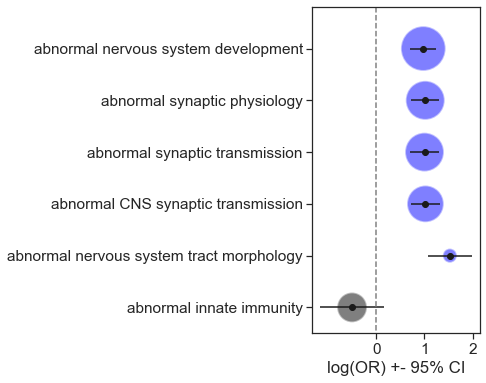

In [41]:
plt.figure(figsize=(3,6))

plt.errorbar(root_KO_df.loc[terms_plot]['log_OR'],np.arange(len(terms_plot)),
            xerr=[np.subtract(root_KO_df.loc[terms_plot]['log_OR'],root_KO_df.loc[terms_plot]['log_OR_CI_lower']),
                   np.subtract(root_KO_df.loc[terms_plot]['log_OR_CI_upper'],root_KO_df.loc[terms_plot]['log_OR'])],color='k',fmt='o')

color_temp = root_KO_df.loc[terms_plot]['MPO_term_type'].map({'brain':'blue','heart':'red','neg_ctrl':'black'})

sns.scatterplot(x=root_KO_df.loc[terms_plot]['log_OR'],
                y=np.arange(len(terms_plot)),size=root_KO_df.loc[terms_plot]['num_genes_in_term'],sizes=(200, 2000),
                alpha=.5,
               hue=color_temp.tolist(),palette={'blue':'blue','red':'red','black':'black'},legend=False)

plt.yticks(np.arange(len(terms_plot)),root_KO_df.loc[terms_plot]['MP_description'])
plt.xticks([0,1,2])
plt.xlabel('log(OR) +- 95% CI')

plt.plot([0,0],[-.8,len(terms_plot)-.5],'--',color='gray')
plt.ylim([-0.8,len(terms_plot)-.5])

plt.gca().invert_yaxis()


## 18. Compute the enrichment of phenotype(s) in NetColoc subsystems.

Some phenotypes may have stronger associations with NetColoc subsystems than with the root node. In this step we calculate the enrichment of selected phenotypes in each NetColoc subsystem.


In [42]:
MP_focal_top = root_KO_df.head(10).index.tolist() # record the top 10 overall
MP_full_results_df = validation.MPO_enrichment_full(hier_df,MPO,mgi_df,MP_focal_top,G_int)
MP_full_results_df.head()

abnormal nervous system development
Genes and Terms to keep: 191
abnormal synaptic physiology
Genes and Terms to keep: 78
abnormal synaptic transmission
Genes and Terms to keep: 73
abnormal CNS synaptic transmission
Genes and Terms to keep: 46
abnormal nervous system tract morphology
Genes and Terms to keep: 62
abnormal nervous system electrophysiology
Genes and Terms to keep: 34
abnormal neuron differentiation
Genes and Terms to keep: 16
abnormal neuron morphology
Genes and Terms to keep: 267
abnormal excitatory postsynaptic currents
Genes and Terms to keep: 9
abnormal hippocampus neuron morphology
Genes and Terms to keep: 12


abnormal nervous system development:-log(OR_p)  \
C416                                       12.116163   
C514                                       -0.000000   
C515                                       -0.000000   
C525                                       -0.000000   
C417                                        6.171345   

      abnormal nervous system development:log_OR  \
C416                                    0.975982   
C514                                    0.000000   
C515                                    0.000000   
C525                                    0.000000   
C417                                    1.046484   

      abnormal nervous system development:num_genes  \
C416                                             68   
C514                                              0   
C515                                              0   
C525                                              0   
C417                                             28   

           abnormal nervous system development:gene_ids  \
C416  ADNP AR ARID1B AUTS2 BCL11A CADPS2 CHD8 COL1A1...   
C514                                                      
C515                                                      
C525                                                      
C417  AR ARID1B BCL11A CREBBP CTNNB1 DPY30 GATAD2A H...   

      abnormal synaptic physiology:-log(OR_p)  \
C416                                11.212276   
C514                                 0.870249   
C515                                -0.000000   
C525                                -0.000000   
C417                                 1.141963   

      abnormal synaptic physiology:log_OR  \
C416                             1.016254   
C514                             1.727414   
C515                             0.000000   
C525                             0.000000   
C417                             0.507190   

      abnormal synaptic physiology:num_genes  \
C416                                      56   
C514                                       1   
C515                                       0   
C525                                       0   
C417                                      14   

                  abnormal synaptic physiology:gene_ids  \
C416  ANK2 ANKRD11 ARID1B BCL11A BEX2 BICD1 CACNA1E ...   
C514                                            ANKRD11   
C515                                                      
C525                                                      
C417  ARID1B BCL11A BEX2 CREBBP CTNNB1 DBN1 HIVEP2 N...   

      abnormal synaptic transmission:-log(OR_p)  \
C416                                  10.757287   
C514                                   0.875077   
C515                                  -0.000000   
C525                                  -0.000000   
C417                                   0.858088   

      abnormal synaptic transmission:log_OR  ...  \
C416                               1.001272  ...   
C514                               1.734047  ...   
C515                               0.000000  ...   
C525                               0.000000  ...   
C417                               0.431712  ...   

      abnormal neuron morphology:num_genes  \
C416                                    72   
C514                                     1   
C515                                     0   
C525                                     0   
C417                                    25   

                    abnormal neuron morphology:gene_ids  \
C416  ALCAM ANK2 ANK3 AR ARID1B AUTS2 BCL11A CADPS2 ...   
C514                                              ALCAM   
C515                                                      
C525                                                      
C417  AR ARID1B BCL11A CTNNB1 DBN1 DNMT3A HBP1 HIVEP...   

      abnormal excitatory postsynaptic currents:-log(OR_p)  \
C416                                           8.307267      
C514                                          -0.000000      
C515                  

In [43]:
print("Top ten terms:")
print("\n".join([mp+" - "+get_MP_description(mp) for mp in MP_focal_top]))

Top ten terms:
MP:0003861 - abnormal nervous system development
MP:0021009 - abnormal synaptic physiology
MP:0003635 - abnormal synaptic transmission
MP:0002206 - abnormal CNS synaptic transmission
MP:0000778 - abnormal nervous system tract morphology
MP:0002272 - abnormal nervous system electrophysiology
MP:0009937 - abnormal neuron differentiation
MP:0002882 - abnormal neuron morphology
MP:0002910 - abnormal excitatory postsynaptic currents
MP:0009939 - abnormal hippocampus neuron morphology


## 19. Annotate the NetColoc systems map with mouse variant data, input genes, and enriched GO terms

In [44]:
# add the best gprofiler annotation
MP_full_results_df['gprofiler_name']=pd.Series(system_name_list,index=hier_df.index.tolist())
# don't annotate the root node
root_node = hier_df['CD_MemberList_Size'].sort_values(ascending=False).head(1).index.tolist()[0]
MP_full_results_df.loc[root_node, 'gprofiler_name']=d1_name+'-'+d2_name+' systems map'

# also add the frac_seeds/num_seeds data here
MP_full_results_df=MP_full_results_df.join(hier_df[['num_d1_seeds','frac_d1_seeds','frac_no_seeds']],
                                          how='left')

MP_full_results_df.head()

NameError: name 'd2_name' is not defined

## 20. Export the NetColoc systems map to NDEx, with default style. 

Default style maps the fraction of seed genes from input set 1 (red) and input set 2 (blue) to node pie charts. The fraction of genes in each system that are in neither input set, but that are implicated by the network propagation are indicated in white.

In [48]:
# Convert G_hier to nice cx network
node_id_to_node_name = nx.get_node_attributes(G_hier, 'name')
for node_id in list(G_hier.nodes):
    del G_hier.nodes[node_id]['name']

G_hier_cx = ndex2.create_nice_cx_from_networkx(G_hier)

for node_id, node in G_hier_cx.get_nodes():
    node['n'] = node_id_to_node_name[node_id]

G_hier_cx.set_name(d1_name+'_systems_map') 
for node_id, node in G_hier_cx.get_nodes():
    data = MP_full_results_df.loc[node['r']]
    for row, value in data.items():
        if (row.find('gene_ids')>-1) or (row=='gprofiler_name'):
            data_type = "string"
            value=str(value)
        else:
            data_type = "double"
            value = str(value) # nice cx can only accept strings as values...
            if value=='inf': # check if inf, set to -1 if so
                value='-1'
            
        G_hier_cx.set_node_attribute(node_id, row, value, type=data_type)

# Restore some hierarchy properties to their state before networkx conversion.
for node_id, node in G_hier_cx.get_nodes():
    for i in np.arange(len(G_hier_cx.nodeAttributes[node_id])):
        dict_temp = G_hier_cx.nodeAttributes[node_id][i]
        if dict_temp['n'] in ['CD_MemberList_Size','CD_MemberList_LogSize','HiDeF_persistence']:
            G_hier_cx.set_node_attribute(node_id, dict_temp['n'], dict_temp['v'], type='double',overwrite=True)
            
# this is required so we can easily make subgraphs from systems
G_hier_cx.set_network_attribute('__CD_OriginalNetwork',
                                       values='0', type='long')
            
          
# use apply_style_from_network-- this should overwrite the existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='f338dea0-117c-11ec-9e8e-0ac135e8bacf')
G_hier_cx.apply_style_from_network(netcoloc_template)

In [50]:
#Upload to NDEx. Enter your ndex username and password. 
# If you are new to ndex, make a new account on the website (ndexbio.org)
G_hier_cx.set_name(d1_name+'_systems_map') 
SERVER = input('NDEx server (probably ndexbio.org): ')
USERNAME = input('NDEx user name: ')
PASSWORD = getpass.getpass('NDEx password: ')
network_uuid_hier = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

NDEx server (probably ndexbio.org): ndexbio.org
NDEx user name: sbrosenthal@health.ucsd.edu
NDEx password: ········
Generating CX


## 21. Apply another template style to NetColoc systems map for mouse knockout view, and export to NDEx. 

Select the property to be mapped to system node colors (should be one of the mouse knockout phenotypes we identified above). In this style, the log odds ratio is mapped to the system node color. Systems which are not significantly enriched for the phenotype are white (p<0.05).


In [51]:
# ------ modify this based on your project. Should be a system identified above -----
# set the property we should map to system node colors
mouse_KO_mapping_property = 'abnormal neuron morphology'

In [52]:
# apply a template style 
G_hier_cx.set_name(d1_name+'_systems_map_mouse_KO:'+mouse_KO_mapping_property) 
# use apply_style_from_network-- this should overwrite existing style
netcoloc_template = ndex2.create_nice_cx_from_server('ndexbio.org',
            uuid='4958993c-df46-11eb-b666-0ac135e8bacf')
raw_cx_st = json.dumps(netcoloc_template.to_cx())

# replace the default template values with mouse_KO_mapping_property
updated_raw_cx = re.sub('COL=abnormal heart development:log_OR', 'COL='+mouse_KO_mapping_property+':log_OR', raw_cx_st)
updated_raw_cx = re.sub('COL=abnormal heart development:-log', 
                        'COL='+mouse_KO_mapping_property+':-log', updated_raw_cx)
updated_raw_cx=json.loads(updated_raw_cx)
netcoloc_template_updated = ndex2.create_nice_cx_from_raw_cx(updated_raw_cx)
G_hier_cx.apply_style_from_network(netcoloc_template_updated)

network_uuid_hier_mouse_KO = G_hier_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX
Generating CX


## 22. Add genes associated with mouse variant phenotypes to NetColoc subnetwork, export to NDEx. 

In [53]:
# add fields to node_df for genes in each mouse_KO phenotype of interest
MP_genes_columns = [c for c in MP_full_results_df.columns.tolist() if c.find(':gene_ids')>-1]

# look up overlapping genes in the root node, add them to node_df
for MP in MP_genes_columns:
    focal_genes = MP_full_results_df.loc[root_node, MP].split(' ')
    node_df[MP]=0
    node_df.loc[focal_genes, MP]=1
node_df.head()

d1_seeds d1_name       z_d1  sum_seeds  \
KDM6B         1     ASD  10.991122          1   
ASXL3         1     ASD  10.905475          1   
TRAF7         1     ASD  10.895410          1   
KMT2E         1     ASD  10.783263          1   
DIP2A         1     ASD  10.639522          1   

       abnormal nervous system development:gene_ids  \
KDM6B                                             0   
ASXL3                                             0   
TRAF7                                             0   
KMT2E                                             0   
DIP2A                                             0   

       abnormal synaptic physiology:gene_ids  \
KDM6B                                      0   
ASXL3                                      0   
TRAF7                                      0   
KMT2E                                      0   
DIP2A                                      0   

       abnormal synaptic transmission:gene_ids  \
KDM6B                                        0   
ASXL3                                        0   
TRAF7                                        0   
KMT2E                                        0   
DIP2A                                        0   

       abnormal CNS synaptic transmission:gene_ids  \
KDM6B                                            0   
ASXL3                                            0   
TRAF7                                            0   
KMT2E                                            0   
DIP2A                                            0   

       abnormal nervous system tract morphology:gene_ids  \
KDM6B                                                  0   
ASXL3                                                  0   
TRAF7                                                  0   
KMT2E                                                  0   
DIP2A                                                  0   

       abnormal nervous system electrophysiology:gene_ids  \
KDM6B                                                  0    
ASXL3                                                  0    
TRAF7                                                  0    
KMT2E                                                  0    
DIP2A                                                  0    

       abnormal neuron differentiation:gene_ids  \
KDM6B                                         0   
ASXL3                                         0   
TRAF7                                         0   
KMT2E                                         0   
DIP2A                                         0   

       abnormal neuron morphology:gene_ids  \
KDM6B                                    0   
ASXL3                                    0   
TRAF7                                    0   
KMT2E                                    0   
DIP2A                                    0   

       abnormal excitatory postsynaptic currents:gene_ids  \
KDM6B                                                  0    
ASXL3                                                  0    
TRAF7                                                  0    
KMT2E                                                  0    
DIP2A                                                  0    

       abnormal hippocampus neuron morphology:gene_ids  
KDM6B                                                0  
ASXL3                                                0  
TRAF7                                                0  
KMT2E                                                0  
DIP2A                                                0

In [54]:

G_prox_cx = ndex2.create_nice_cx_from_networkx(G_prox)
G_prox_cx.set_name(d1_name+'_NetColoc_subgraph') 
for node_id, node in G_prox_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_prox_cx.set_node_attribute(node_id, row, value, type=data_type)

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_prox_cx.apply_template('ndexbio.org','834b6ad4-d2ea-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc = G_prox_cx.upload_to(SERVER, USERNAME, PASSWORD)

Generating CX


## 23. Upload cosine-similarity transformed NetColoc subnetwork to NDEx

In [55]:
#Annotate network
print("Number of nodes in cosine similarity network:", len(G_cosSim.nodes()))
print("Number of edges in cosine similarity network:", len(G_cosSim.edges()))
G_cosSim_cx = ndex2.create_nice_cx_from_networkx(G_cosSim)
G_cosSim_cx.set_name(d1_name+'_NetColoc_subgraph_CosSim95') 
for node_id, node in G_cosSim_cx.get_nodes():
    data = node_df.loc[node['n']]
    for row, value in data.items():
        if row == 'd1_seeds' or row == 'd2_seeds' or row=='sum_seeds':
            data_type = 'double'
        elif row=='d1_name' or row=='d2_name':
            data_type='string'
        else:
            data_type = 'double'
        G_cosSim_cx.set_node_attribute(node_id, row, value, type=data_type)
        
        

# apply a template style (834b6ad4-d2ea-11eb-b666-0ac135e8bacf)
G_cosSim_cx.apply_template('ndexbio.org','2cbed84b-e5c3-11eb-b666-0ac135e8bacf')

network_uuid_NetColoc_CosSim = G_cosSim_cx.upload_to(SERVER, USERNAME, PASSWORD)

Number of nodes in cosine similarity network: 416
Number of edges in cosine similarity network: 1864
Generating CX


## 24. Add 4 networks from above to network set

In [57]:
# append the datestring to the network set to guarantee uniqueness
datestr = str(datetime.now())
networkSetURL=ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).create_networkset(d1_name+' network set: '+datestr,'network set for '+d1_name+' NetColoc subgraph and systems map')
networkSetURL

'https://www.ndexbio.org/v2/networkset/a860fa0f-5198-11ed-ae36-0ac135e8bacf'

In [58]:
# parse out UUID from URL strings
networkSetUUID = networkSetURL.split('/')[-1]
networkSetUUID

networkURLs = [network_uuid_NetColoc,network_uuid_NetColoc_CosSim,network_uuid_hier,network_uuid_hier_mouse_KO]
networkUUIDs = [n.split('/')[-1] for n in networkURLs]

ndex2.client.Ndex2(host=SERVER,username=USERNAME,password=PASSWORD).add_networks_to_networkset(networkSetUUID,
                                                                                              networkUUIDs)


'https://www.ndexbio.org/v2/networkset/a860fa0f-5198-11ed-ae36-0ac135e8bacf/members'